In [1]:
import numpy as np 
import pandas as pd
import os
import math
import random
import cv2
from time import time

import matplotlib.pyplot as plt
import quandl
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data

import ColorLog as debug

from load_data import labelFpsDataLoader, labelTestDataLoader

In [2]:
# DEVICE = "cuda"
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

NUM_PROV = len(provinces)
NUM_ALPB = len(alphabets)
NUM_ADS = len(ads)



In [3]:
# data loading 
# image size 720x1160x3 


image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")


def list_images(basePath, contains=None):
    # return the set of files that are valid
    print(debug.INFO+"Loading data under %s"%basePath)
    return list_files(basePath, validExts=image_types, contains=contains)


def list_files(basePath, validExts=None, contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if validExts is None or ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename)
                yield imagePath
                
class labelFpsDataLoader(Data.Dataset):
    def __init__(self, img_dir, imgSize, is_transform=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in list_images(img_dir[i])]
        # self.img_paths = os.listdir(img_dir)
        # print self.img_paths
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)
#         plt.imshow(img[:,:,::-1])
#         plt.show()
        # img = img.astype('float32')
        lbl = img_name.split('/')[-1].rsplit('.', 1)[0].split('-')[-3]

        iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')
        # fps = [[int(eel) for eel in el.split('&')] for el in iname[3].split('_')]
        # leftUp, rightDown = [min([fps[el][0] for el in range(4)]), min([fps[el][1] for el in range(4)])], [
        #     max([fps[el][0] for el in range(4)]), max([fps[el][1] for el in range(4)])]
        
#         print(debug.DEBUG,iname)
        
        [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
        ori_w, ori_h = [float(int(el)) for el in [img.shape[1], img.shape[0]]]
        new_labels = [(leftUp[0] + rightDown[0]) / (2 * ori_w), (leftUp[1] + rightDown[1]) / (2 * ori_h),
                      (rightDown[0] - leftUp[0]) / ori_w, (rightDown[1] - leftUp[1]) / ori_h]
        croppedImage = img[leftUp[1]:rightDown[1],leftUp[0]:rightDown[0]]
        resizedImage = cv2.resize(croppedImage, self.img_size)
#         cv2.imshow('plate',resizedImage)
#         cv2.waitKey(0)
#         print(resizedImage.shape)
        resizedImage = np.transpose(resizedImage, (2,0,1))
        resizedImage = resizedImage.astype('float32')
        resizedImage /= 255.0
#         plt.imshow(np.transpose(resizedImage, (1,2,0)))
#         plt.show()
        
#         cv2.imshow('plate',np.transpose(resizedImage, (1,2,0)))
#         cv2.waitKey(0)
        
        return resizedImage, new_labels, lbl, img_name, iname
    
class labelLoader(Data.Dataset):
    def __init__(self, img_dir, imgSize, is_transform=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in list_images(img_dir[i])]
        # self.img_paths = os.listdir(img_dir)
        # print self.img_paths
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
#         img = cv2.imread(img_name)
#         # img = img.astype('float32')
#         resizedImage = cv2.resize(img, self.img_size)
#         resizedImage = np.transpose(resizedImage, (2,0,1))
#         resizedImage = resizedImage.astype('float32')
#         resizedImage /= 255.0
        lbl = img_name.split('/')[-1].rsplit('.', 1)[0].split('-')[-3]

        iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')
        # fps = [[int(eel) for eel in el.split('&')] for el in iname[3].split('_')]
        # leftUp, rightDown = [min([fps[el][0] for el in range(4)]), min([fps[el][1] for el in range(4)])], [
        #     max([fps[el][0] for el in range(4)]), max([fps[el][1] for el in range(4)])]
        
#         print(debug.DEBUG,iname)
        
        [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
#         ori_w, ori_h = [float(int(el)) for el in [img.shape[1], img.shape[0]]]
#         new_labels = [(leftUp[0] + rightDown[0]) / (2 * ori_w), (leftUp[1] + rightDown[1]) / (2 * ori_h),
#                       (rightDown[0] - leftUp[0]) / ori_w, (rightDown[1] - leftUp[1]) / ori_h]

        return lbl, img_name, iname

[INFO] -- start loading data...
[INFO] -- Loading data under CCPD2019/ccpd_base
[INFO] -- finish loading
(3, 96, 256)


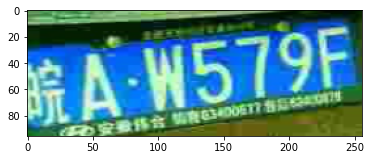

(96, 256, 3)


In [4]:
path = "CCPD2019/ccpd_base"
imgsize = (480,480)
platesize = (256,96)
print(debug.INFO+"start loading data...")
dst = labelFpsDataLoader([path],platesize)
# dst = labelLoader([path],imgsize)
print(debug.INFO+"finish loading")
# sizes = []
# for _,_,iname in dst:
#     [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] 
#                        for el in iname[2].split('_')]
#     sizes.append([leftUp[0]-rightDown[0],leftUp[1]-rightDown[1]])

# mean, std = np.mean(sizes, axis=0),np.std(sizes, axis=0)
# print(mean,std)
#     [-252.62252245  -94.97832957] [61.46956803 27.42365916]
for img,_,_,_,iname in dst:
    print(img.shape)
    img =np.transpose(img*255, (1,2,0)).astype("int")
    img = img[:,:,::-1]
    plt.imshow(img)
    plt.show()
#     print(img)
    print(img.shape)
#     cv2.imshow('plate',img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    break


In [5]:
class DigitRecog(nn.Module): 
    def __init__(self, imgSize):

        super(DigitRecog, self).__init__()
        self.name = "DigitRecog"
        
        self.stack1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.stack2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.stack3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.stack4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.stack5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.activations = nn.Sequential(
            self.stack1,
            self.stack2,
            self.stack3,
            self.stack4,
            self.stack5
        )
        self.Length = int((imgSize[0]/(2**5))*(imgSize[1]/(2**5)))*512
        interft = 4096
        self.classifier1 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_PROV)
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ALPB)
        )
        
        self.classifier3 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
        self.classifier4 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
        self.classifier5 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
        self.classifier6 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
        self.classifier7 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
    def forward(self, x):
#         x = self.activations(x)
#         print(x.shape)
        x = self.stack1(x)
#         print(x.shape)
        x = self.stack2(x)
#         print(x.shape)
        x = self.stack3(x)
#         print(x.shape)
        x = self.stack4(x)
#         print(x.shape)
        x = self.stack5(x)
#         print(x.shape)
        
        x = x.view(x.size(0),-1)
#         print(self.Length, x.shape)
        prov = self.classifier1(x)
        alpb = self.classifier2(x)
        ads1 = self.classifier3(x)
        ads2 = self.classifier4(x)
        ads3 = self.classifier5(x)
        ads4 = self.classifier6(x)
        ads5 = self.classifier7(x)
        return prov,alpb,ads1,ads2,ads3,ads4,ads5   


In [6]:

def eval(model, test_dirs):
    count, error, correct = 0, 0, 0
    dst = labelFpsDataLoader(test_dirs, PLATESIZE)
    testloader = Data.DataLoader(dst, batch_size=1, shuffle=True, num_workers=8)
    start = time()
    for i, (XI,_, labels, ims, _) in enumerate(testloader):
        count += 1
        YI = [[int(ee) for ee in el.split('_')[:7]] for el in labels]
        if use_gpu:
            x = Variable(XI.cuda(0))
        else:
            x = Variable(XI)
        # Forward pass: Compute predicted y by passing x to the model

        y_pred = model(x)

        outputY = [el.data.cpu().numpy().tolist() for el in y_pred]
        labelPred = [t[0].index(max(t[0])) for t in outputY]
        
        def isEqual(labelGT, labelP):
            compare = [1 if int(labelGT[i]) == int(labelP[i]) else 0 for i in range(7)]
            # print(sum(compare))
            return sum(compare)

        #   compare YI, outputY
        try:
            if isEqual(labelPred, YI[0]) == 7:
                correct += 1
            else:
                pass
        except:
            print(debug.WARN+"val fails")
            error += 1
            
    return count, correct, error, float(correct) / count, (time() - start) / count


def train_model(model, trainloader, criterion, optimizer,batchSize, testDirs,storeName, num_epochs=25, logFile="./train_log.txt"):
    # since = time.time()
    use_gpu = True
    lrScheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
    for epoch in range(num_epochs):
        lossAver = []
        model.train(True)
        lrScheduler.step()
        start = time()
        print(debug.INFO+"Epoch {} started at {}".format(epoch,start))

        for i, (XI, _, labels, _, _) in enumerate(trainloader):
            if not len(XI) == batchSize:
                
                continue

            YI = [[int(ee) for ee in el.split('_')[:7]] for el in labels]
#             Y = np.array([el.numpy() for el in Y]).T
            if use_gpu:
                x = Variable(XI.cuda())
                lbl = Variable(torch.LongTensor(YI).cuda())
#                 y = Variable(torch.FloatTensor(Y).cuda(), requires_grad=False)
            else:
                x = Variable(XI)
                lbl = Variable(torch.LongTensor(YI))
#                 y = Variable(torch.FloatTensor(Y), requires_grad=False)
            # Forward pass: Compute predicted y by passing x to the model
    
#             print(debug.INFO+"input shape {}".format(x.shape))
            y_pred = model(x)
#             print(debug.INFO+"output shape {}".format([yy.shape for yy in y_pred]))
#             try:
#                 y_pred = model(x)
#                 print(debug.INFO+"output shape {}".format(y_pred.shape))
                
#             except:
#                 print(debug.WARN+"iter %d model prediction fails"%i)
#                 continue
                
            # Compute and print loss
            loss = 0.0
#             train_correct = []
#             loss += 0.8 * nn.L1Loss().cuda()(fps_pred[:][:2], y[:][:2])
#             loss += 0.2 * nn.L1Loss().cuda()(fps_pred[:][2:], y[:][2:])
            for j in range(7):
                l = lbl[:,j]
                loss += criterion(y_pred[j], l)
#                 train_correct.append(np.argmax(y_pred[j],axis=1))
#                 acc = len(train_correct[train_correct==0])/len(train_correct)

#             def isEqual(labelGT, labelP):
#                 compare = [1 if int(labelGT[i]) == int(labelP[i]) else 0 for i in range(7)]
#                 # print(sum(compare))
#                 return sum(compare)
            
#             for ii in range(batchSize):
#                 if isEqual(labelPred, YI[ii]) == 7:
#                     correct += 1


                    
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             print(loss)
            lossAver.append(loss.item())

#             try:
#                 print(loss)
#                 lossAver.append(loss.data[0])
#             except:
#                 print(debug.ERR+"iter %d lossAver append error"%i)

            if i % 50 == 1:
                with open(logFile, 'a') as outF:
                    outF.write('trained %s images, use %s seconds, loss %s\n' % (i*batchSize, time() - start, sum(lossAver) / len(lossAver) if len(lossAver)>0 else 'NoLoss'))
                torch.save(model.state_dict(), storeName)
        print ('Epoch %s Avrg Training loss %s Elapsed %s\n' % (epoch, sum(lossAver) / len(lossAver), time()-start))
        
        model.eval()
        count, correct, error, precision, avgTime = eval(model, testDirs)
        with open(logFile, 'a') as outF:
            outF.write('Epoch %s Avrg Training loss %s Elapsed %s\n' % (epoch, sum(lossAver) / len(lossAver), time() - start))
            outF.write('************* Validation: total %s error %s precision %s avgTime %s\n' % (count, error, precision, avgTime))
        torch.save(model.state_dict(), storeName + str(epoch))
        print('************* Validation: total %s error %s precision %s avgTime %s\n' % (count, error, precision, avgTime))
    return model


In [ ]:

torch.cuda.set_device(0)
torch.cuda.empty_cache()

TRAINDIR = ['CCPD2019/train']
TESTDIR = ['CCPD2019/test']
VALDIR = ['CCPD2019/val']

LR = 0.001
PLATESIZE = (256,96)
BATCHSIZE = 2
EPOCH = 300


model = DigitRecog(PLATESIZE).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=LR)
# lrScheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# optimizer_conv = optim.RMSprop(model_conv.parameters(), lr=0.01, momentum=0.9)
# optimizer_conv = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(debug.INFO+"Start loading dataset...")
dst = labelFpsDataLoader(TRAINDIR, PLATESIZE)
print(debug.INFO+"Got dataset size %d"%len(dst))
trainloader = Data.DataLoader(dst, batch_size=BATCHSIZE, shuffle=True, num_workers=8)
print(debug.INFO+"Done loading dataset")

print(debug.INFO+"Start training")
model = train_model(model=model, trainloader=trainloader, criterion=criterion, optimizer=optimizer,
            batchSize=BATCHSIZE, testDirs=VALDIR,storeName='./weight/DigitRecog.pth', num_epochs=EPOCH, logFile="./train_log.txt")

[INFO] -- Start loading dataset...
[INFO] -- Loading data under CCPD2019/train
[INFO] -- Got dataset size 100000
[INFO] -- Done loading dataset
[INFO] -- Start training
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
[INFO] -- Epoch 0 started at 1618141135.261684


/media/largeHDD/yile/.conda/envs/tradt/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
num_parameters = (3*3)*(3*64+64*64+64*128+128*128+128*256+256*256+256*256+256*256+256*512+512*512+512*512+512*512+512*512+512*512+512*512+512*512)+(64+64+128+128+256+256+256+256+512+512+512+512+512+512+512+512)+7*(24*512*4096+4096*4096+4096+4096)+(7*4096+1)*(NUM_PROV+NUM_ALPB+5*NUM_ADS)
num_variables = BATCHSIZE*(256*96*(3+64+64)+128*48*(128+128)+64*24*(256+256+256+256)+32*12*(512+512+512+512)+16*6*(512+512+512+512)+7*(4096+4096)+(NUM_PROV+NUM_ALPB+5*NUM_ADS))
model_size = num_parameters + 2*num_variables
print("number of parameters: %d floating-point"%num_parameters)
print("%d Bytes"%(num_parameters*4))
print("%0.2f MB"%(num_parameters*4/1024/1024))
print("%0.2f GB"%(num_parameters*4/1024/1024/1024))
print("number of variables: %d floating-point"%num_variables)
print("%d Bytes"%(num_variables*4))
print("%0.2f MB"%(num_variables*4/1024/1024))
print("%0.2f GB"%(num_variables*4/1024/1024/1024))
print("number of variables: %d floating-point"%model_size)
print("%d Bytes"%(model_size*4))
print("%0.2f MB"%(model_size*4/1024/1024))
print("%0.2f GB"%(model_size*4/1024/1024/1024))

In [ ]:
torch.cuda.empty_cache()